# Proyecto de Máquinas de Aprendizaje - ILI393
## _Identificación facial cuando existen pocos ejemplos por clase_

## El Problema

El problema consiste en la correcta identificación y reconocimiento facial, dado el caso particular en donde existen muy pocos ejemplos por clase (por persona) para entrenar los algoritmos algoritmos de clasificación. La mayoría de los enfoques usados en este tipo de problemas consisten en encontrar una buena representación de las características importantes de las caras, para posteriormente realizar algún tipo de búsqueda (jerárquica, nearest neighbors, etc). Sin embargo se propone aquí resolver el problema con tres algoritmos de clasificación distintos: Linear Discriminant Analysis, Support Vector Machines (con kernel lineal y radio basal) y por Convolutional Neural Networks.

Los dataset a ocupar son [Faces94](http://cswww.essex.ac.uk/mv/allfaces/faces94.html), [Faces95](http://cswww.essex.ac.uk/mv/allfaces/faces95.html) y [Faces96](http://cswww.essex.ac.uk/mv/allfaces/faces96.html). Cada uno de los datasets consiste en 20 imágenes de individuos, y variable cantidad de individuos. Los datasets están ordenados en cuanto a su complejidad de reconocimiento de menor a mayor. Se muestran a continuación imágenes representativas de Faces94, Faces95 y Faces96 respectivamente.

<img src="faces94ex.jpg">

<img src="faces95ex.jpg">

<img src="faces96ex.jpg">

Para cada uno de estos datasets, se crearon training y testing sets correspondientes. La metodología fue la siguiente: Para cada dataset (94,95,96) se tomaron aleatoriamente entre 2-5 fotos por clase (por persona) para formar los training sets correspondientes, y las restantes 15-18 fotos se dejaron para crear los testing sets correspondientes. Vale decir, si se entrena con train94/5pc (faces94, 5 samples per class) entonces se prueba con test94/15pc (faces94, 15 samples per class). Cumpliendo de este modo con la restricción de tener pocos samples para entrenar los algoritmos.

**Observación**: Por el momento se trabaja sólo con Faces94 y Faces95.

## Enfoque 1: Linear Discriminant Analysis

La implementación ocupada corresponde la de Scikit-Learn. Para cada una de las clases (personas) genera la función discriminante lineal $\delta_k$, que permite diferenciar a cada una de las clases. Los dos supuestos fuertes que se realizan sobre los datasets al ocupar este método, son que 1) La probabilidad multivariada de las características $P(x_m | y=k)$ se distribuye normal, y que 2) La matriz de covarianza para cada una de las clases es igual.

Debido a que LDA es un modelo generativo sin _hiperparámetros_, es que no es necesario realizar cross-validation para el modelo. Esto es una gran ventaja, pues ahora gran tiempo de computación (comparado con los otros métodos). Sin embargo, como se verá más adelante, paga este costo de simplicidad, entregando resultados menos precisos y generalizantes.

### 1) LDA con Faces94

#####################################################################################
Dataset faces94: 2 samples per class
Error rate: 0.0138888888889


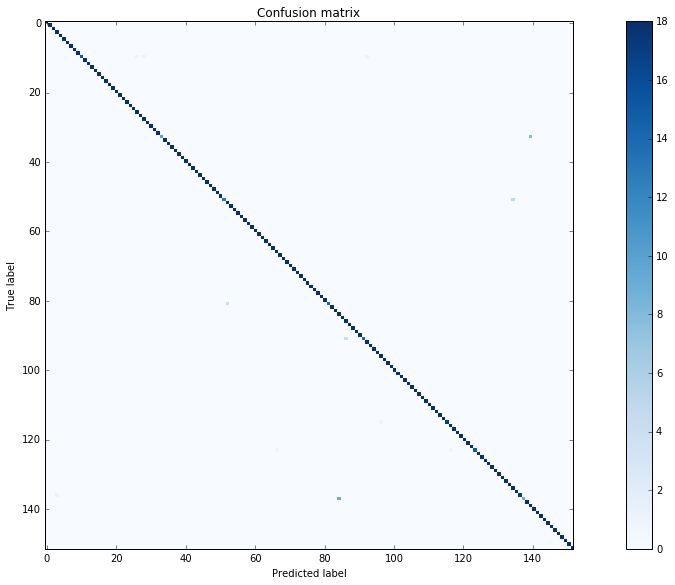

In [ ]:
for i in range(2,6):
    solve_lda('faces94',i)

**Análisis:**
+ De las matrices de confusión, se nota que el dataset Faces94 es muy "fácil" y por lo tanto los resultados son casi perfectos. Si se ven las imágenes en este, se pude notar que todas son muy parecidas entre ellas, vale decir, hay poca variación en la pose, expresión, iluminación, etc. Por lo cual esta data es fácilmente separable por hiperplanos.
+ De todos modos, a medida que aumentan las muestras por clase, el error rate tiende a disminuir.

### LDA con Faces95

In [ ]:
for i in range(2,6):
    solve_lda('faces95',i)

**Análisis:**
+ Se nota claramente que el dataset Faces95 es un dataset mucho más complejo que el anterior.
+ Los error rates son claramente mayores, siendo estos muy altos para los casos en donde hay pocos ejemplos por clase.
+ De todas maneras el comportamiento tiende a mejorar cuando existen más muestras por clase.

## Enfoque 2: Support Vector Machines

El enfoque seguido en esta sección, es la implementación y entrenamiento de multiclass SVM's con kernels tanto lineales como gaussianos, para cumplir con el objetivo de clasificar la data. Debido a que los datasets fueron generados de manera balanceada en cuanto a las clases, se utilizan _C-SVM's_. La implementación ocupada corresponde a la de Scikit-Learn, la cual advierte: _“SVC  implement one-against-one” approach (Knerr et al., 1990) for multi- class classification."_

Para la selección de _hiperparámetros_ $C$ y $\gamma$ (en kernels rbf) se realiza 5-fold cross validation sobre cada training set, con la ayuda de grid search.

Debido a que las dimensiones de las imágenes (200x180=36000) corresponden al total de features de cada foto, se ha decidido realizar una reducción de dimensionalidad para mejorar los tiempos de entrenamientos y eficiencia, así como también tomar las características realmente importantes (aquellas que permiten diferencias entre las clases).

Como técnica de reducción de dimensionalidad, se ha decidido ocupar LDA como reducción de dimensionalidad supervisada, representación tambien conocida como [_Fisher Faces_](http://www.scholarpedia.org/article/Fisherfaces). Esta técnica
intenta encontrar un subespacio donde proyectar la data que permita diferenciar de mejor manera las clases. Dicho de otro modo, se intenta maximizar la **inter-class variance**  y minimizar la varianza **intra-class variance**.

Básicamente los hiperplanos que conforman el subespacio de representación, corresponden a la funciones discriminantes que genera el modelo en LDA. La idea se plasma en la siguiente representación

<img src="lineardisc.jpg">

en donde cada dato se proyecta en los hiperplanos discriminantes, para formar la representación. El número de máximo de discriminantes es $\min(\text{dimensiones},\text{clases}-1)$, por lo tanto en un problema con muchas más dimensiones (features) que clases, la reducción de dimensionalidad es mayor (este problema es precisamente el caso). Se pueden ocupar menos discriminantes, pero para los experimentos que se muestran a continuación se ocupan todos.

### 1) Linear SVM

**Observaciones:**
+ Los rangos de los parámetros fueron determinados empíricamente, probando aquellos que entregan resultados coherentes y útiles en los datasets respectivos.
+ Los scores que se muestran, corresponden a la precisión o tasa de acierto (contrario al error rate). Valores más cercanos a 1 son deseables.

In [ ]:
#Setting parameters to try on Linear-SVM for Faces94 and Faces95
C1 = np.linspace(1e-3, 1e-2, 20, endpoint=True)

### Linear-SVM con Faces94

In [ ]:
for spc in range(2,6):
    solve_svm('faces94', spc, 'linear', C1)

**Análisis:**
+ Sucede lo mismo que con LDA: Faces94 es muy fácil de separar por hiperplanos y por lo tanto obtiene muy buen resultado también la SVM con kernel lineal.
+ Los error rates obtenidos aquí son ligeramente inferiores a los obtenidos con LDA.
+ Sigue el patrón de mejorar los resultados a medida que aumentan las muestras por clase.

### Linear-SVM con Faces95

In [ ]:
for spc in range(2,6):
    solve_svm('faces95', spc, 'linear', C1)

**Análisis:**
+ Los resultados aquí obtenidos, mejoran en una cantidad notoria respecto a el mismo dataset aplicado con LDA. Sin embargo, no hay que olvidar que aquí se tuvo que realizar un proceso de cross-validation para establecer _hiperparámetros_ y en LDA no.
+ Se mantiene el patrón de mejorar los resultados a medida que aumentan los ejemplos por clase.
+ Notar que los resultados obtenidos para pocos ejemplos por clase (2-3) son peores que los que obtiene LDA.

### 2) Kernel-SVM

**Observaciones:**
+ Los rangos de los parámetros fueron determinados empíricamente, probando aquellos que entregan resultados coherentes y útiles en los datasets respectivos.
+ Los scores que se muestran, corresponden a la precisión o tasa de acierto (contrario al error rate). Valores más cercanos a 1 son deseables.

In [ ]:
#setting parameters to try one kernel-svm
C2 = np.linspace(1e+0, 1e+1, 6, endpoint=True)
Gamma = np.linspace(1e-3, 1e-2, 6, endpoint=True)

### Kernel-SVM con Faces94 

In [ ]:
for spc in range(2,6):
    solve_svm('faces94', spc, 'rbf', C2, Gamma)

**Análisis:**
+ Los resultados obtenidos son similares a los anteriores. Como se vio anteriormente, este dataset es muy fácilmente separable por hiperplanos. El hecho de que con kernels rbf pueda aprender fronteras de decisión más complejas por lo tanto no está ayudando mucho.
+ Extrañamente el error rate aumenta en el caso de 5 ejemplos por clase.
+ Los resultados podrían mejorar aún más si se realiza las selección de _hiperparámetros_ en una malla más fina, pero esto requeriría de mucho tiempo de computación.

### Kernel-SVM con Faces95

In [ ]:
for spc in range(2,6):
    solve_svm('faces95', spc, 'rbf', C2, Gamma)

**Análisis:**
+ Los resultados obtenidos para 4-5 ejemplos por clase no son muy distintos a los de los enfoques anteriores sobre este mismo dataset. Sin embargo para 2-3 ejemplos por clases, tiene un muy buen resultado respecto de los otros enfoques.
+ Los resultados podrían mejorar aún más si se realiza las selección de _hiperparámetros_ en una malla más fina, pero esto requeriría de mucho tiempo de computación.

## Enfoque 3: Convolutional Neural Network

## Anexo de Código

### Configuración del notebook

In [12]:
%matplotlib inline
import os
import time
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm, grid_search

import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum

### Helper functions

In [28]:
"""
> function to load data from path directory to a matrix.
> each row of the resulting matrix, corresponds to a flattened image
  in grayscale format
"""
def load_data(path, spc, stacked=False):
    #total number of classes
    M = len(os.listdir(path))
    #dimensions of each image
    N = 200*180
    #matrix with features
    if stacked:
        data = np.empty((M*spc,1,200,180))
    else: 
        data = np.empty((M*spc,N))
    labels = np.empty(M*spc)
    #index of data matrix
    m = 0
    for i in range(1,M+1):
        tgt = path+str(i)+'/'
        pics = os.listdir(tgt)
        for pic in pics:
            if stacked:
                #store each image, as a bidimensional array in data matrix
                data[m,0,:,:] = cv.imread(tgt+pic, cv.IMREAD_GRAYSCALE)
            else:
                #store each flattened image, as a row in data matrix
                data[m,:] = cv.imread(tgt+pic, cv.IMREAD_GRAYSCALE).ravel()
            labels[m] = i
            m += 1
    return (data.astype(np.float32), labels.astype(np.uint8))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(15,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
"""
This is just a simple helper function iterating over training data in
mini-batches of a particular size, optionally in random order. It assumes
data is available as numpy arrays. For big datasets, you could load numpy
arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
own custom data iteration function. For small datasets, you can also copy
them to GPU at once for slightly improved performance. This would involve
several changes in the main program, though, and is not demonstrated here.
"""

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    M = inputs.shape[0]
    num_batches = M/batchsize
    if shuffle:
        indices = np.arange(M)
        np.random.shuffle(indices)
    for batch_idx in range(num_batches):
        start_idx = batch_idx*batchsize
        if batch_idx==num_batches-1: end_idx = M
        else: end_idx = start_idx+batchsize
        if shuffle: 
            excerpt = indices[start_idx:end_idx]
        else:
            excerpt = slice(start_idx, end_idx)
        yield inputs[excerpt], targets[excerpt]

### Funciones de error

In [24]:
def precision(y_ts, y_pd):
    #true positives
    tp = (y_ts==y_pd).sum()
    #total of predictions
    n = y_ts.shape[0]
    return tp/np.float(n)

def error_rate(y_ts, y_pd):
    return 1-precision(y_ts, y_pd)

### Funciones para LDA

In [33]:
def solve_lda(dataset, spc):
    #samples per class on training set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #training and testing paths
    tr_path = './db/train'+dataset[-2:]+'/tr-{0}pc-{1}/'
    ts_path = './db/test'+dataset[-2:]+'/ts-{0}pc-{1}/'
    
    #iterating through datasets
    for set_num in range(20):
        #loading training and testing set
        X_tr,y_tr = load_data(tr_path.format(spc_tr,set_num), spc_tr)
        X_ts,y_ts = load_data(ts_path.format(spc_ts,set_num), spc_ts)
        #creating LDA object and fitting the testing data
        clf = LDA()
        clf.fit(X_tr, y_tr)
        #making predictions
        y_pd = clf.predict(X_ts)

        print "#####################################################################################"
        print "Dataset {0}: {1} samples per class".format(dataset,spc)
        #computing the confussion matrix and plotting results
        print "Error rate: {0}".format(error_rate(y_ts,y_pd))
        cm = confusion_matrix(y_ts, y_pd)
        plot_confusion_matrix(cm)
        print "#####################################################################################"
        #releasing memory of big objects
        del X_tr, X_ts, clf, cm

### Funciones para SVM

In [16]:
"""
Supervised dimensionality reduction through LDA
"""
def fisher_faces(X, y):
    #supervised learning through LDA
    #finding the discriminant functions
    ff = LDA()
    ff.fit(X,y)
    #proyect the data into linear discriminant hyperplanes
    return ff

"""
5-fold cross validation y Grid search
para determinar el mejor parametro C en
linear svm
"""
def cross_linear_svm(X, y, C):
    #generating 5-folds
    M,_ = X.shape
    kf = KFold(M, n_folds=5)
    #parameters to try
    params = {'C':C}
    #Setting grid search for linear-svm and 5-fold cross validation
    svc = svm.SVC(kernel='linear')
    clf = grid_search.GridSearchCV(svc, params, cv=kf, n_jobs=4)
    #make it
    clf.fit(X, y)
    #return best parameters and grid scores
    return clf.best_params_['C'] , clf.grid_scores_


"""
5-fold cross validation y Grid search
para determinar el mejor parametro C y
gamma en rbf svm
"""
def cross_rbf_svm(X, y, C, Gamma):
    #generating 5-folds
    M,_ = X.shape
    kf = KFold(M, n_folds=5)
    #parameters to try
    params = {'C':C, 'gamma':Gamma}
    #Setting grid search for rbf-svm and 5-fold cross validation
    svc = svm.SVC(kernel='rbf')
    clf = grid_search.GridSearchCV(svc, params, cv=kf, n_jobs=4)
    #make it
    clf.fit(X, y)
    #return best parameters and grid scores
    return clf.best_params_['C'], clf.best_params_['gamma'] , clf.grid_scores_


def solve_svm(dataset, spc, kernel, C, Gamma=None):
    #samples per class on training set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #loading training and testing set
    X_tr,y_tr = load_data('./db/train'+dataset[-2:]+'/', spc_tr)
    X_ts,y_ts = load_data('./db/test'+dataset[-2:]+'/', spc_ts)
    #projecting into discriminant space
    ff = fisher_faces(X_tr, y_tr)
    X_tr = ff.transform(X_tr)
    X_ts = ff.transform(X_ts)
    #choosing best C (and gamma) through 5-fold cross-validation and grid search
    if kernel=='linear':
        c,grid_scores = cross_linear_svm(X_tr, y_tr, C)
    elif kernel=='rbf':
        c,gamma,grid_scores = cross_rbf_svm(X_tr, y_tr, C, Gamma)
    #fitting the model
    if kernel=='linear':
        clf = SVC(kernel='linear', C=c)
    elif kernel=='rbf':
        clf = SVC(kernel='rbf', C=c, gamma=gamma)    
    clf.fit(X_tr,y_tr)
    #making predictions
    y_pd = clf.predict(X_ts)
    print "#####################################################################################"
    print "Dataset {0}: {1} samples per class".format(dataset,spc)
    print "Error rate: {0}".format(error_rate(y_ts, y_pd))
    print "Best C: {0}".format(c)
    if kernel=='rbf':
        print "Best gamma: {0}".format(gamma)
    print "Grid scores:"
    for i in range(len(grid_scores)):
        print grid_scores[i]
    #computing the confussion matrix and plotting results
    cm = confusion_matrix(y_ts, y_pd)
    plot_confusion_matrix(cm)
    print "#####################################################################################"